# TP3

Encontrar el logotipo de la gaseosa dentro de las imagenes provistas en Material_TPs/TP3/images a partir del template Material_TPs/TP3/template

In [1]:
# Importing necessary libraries
import cv2 as cv
import numpy as np
import math
import matplotlib.pyplot as plt
from imutils.object_detection import non_max_suppression

In [2]:
image_paths = [
    './images/coca_logo_1.png', 
    './images/coca_logo_2.png', 
    './images/COCA-COLA-LOGO.jpg',
    './images/coca_multi.png', 
    './images/coca_retro_1.png', 
    './images/coca_retro_2.png', 
    './images/logo_1.png'
]

image_template_path = './template/pattern.png'

## 1. (4 puntos) Obtener una deteccion del logo en cada imagen sin falsos positivos.

In [3]:
# Function definitions

def load_and_convert_image(path, color_mode=cv.COLOR_BGR2RGB):
    """Loads an image and converts it to the specified color space."""
    image = cv.imread(path)
    return cv.cvtColor(image, color_mode)

def load_and_convert_images(paths, color_mode=cv.COLOR_BGR2RGB):
    """Loads multiple images and converts them to the specified color space."""
    return [load_and_convert_image(path, color_mode) for path in paths]

def apply_edge_detection(image, threshold1=50, threshold2=200):
    """Applies the Canny algorithm for edge detection."""
    return cv.Canny(image, threshold1, threshold2)

def resize_and_detect_edges(image, scale):
    """Resizes the image and applies the Canny algorithm."""
    resized_image = cv.resize(image, None, fx=scale, fy=scale)
    edge_detected_image = apply_edge_detection(resized_image)
    return resized_image, edge_detected_image

def find_optimal_match(image, template, method, optimal_value, optimal_match, scale):
    """Finds the optimal match of the template in the image using the specified method."""
    match_result = cv.matchTemplate(image, template, method)
    _, max_val, _, max_loc = cv.minMaxLoc(match_result)

    if max_val > optimal_value:
        optimal_value = max_val
        optimal_match = (max_loc, scale)

    return optimal_value, optimal_match

def draw_rectangle(image, top_left_scaled, bottom_right, color=(0,255,0), thickness=3):
    """Draws a rectangle on the image at the specified coordinates."""
    output_image = image.copy()
    cv.rectangle(output_image, top_left_scaled, bottom_right, color=color, thickness=thickness)
    return output_image

In [4]:
def detect_logo_in_image(gray_image, rgb_image, template, method):
    """Detects the logo in the image using the provided template."""
    template_width, template_height = template.shape[::-1]
    scales = np.linspace(0.1, 4.0, 20)[::-1] 
    optimal_value, optimal_match = 0, 0
    match_result = None

    for scale in scales:
        resized_image, edge_detected_image = resize_and_detect_edges(gray_image, scale)
        resized_width, resized_height = resized_image.shape[::-1]

        if resized_width < template_width or resized_height < template_height:
            break

        optimal_value, optimal_match = find_optimal_match(edge_detected_image, template, method, optimal_value, optimal_match, scale)
        match_result = cv.matchTemplate(edge_detected_image, template, method)

    top_left, optimal_scale = optimal_match
    top_left_scaled = (int(top_left[0] / optimal_scale), int(top_left[1] / optimal_scale))
    bottom_right = (int((top_left[0] + template_width)/ optimal_scale), int((top_left[1] + template_height) / optimal_scale))

    output_image = draw_rectangle(rgb_image, top_left_scaled, bottom_right)

    return output_image, optimal_scale, optimal_value, match_result

In [5]:
def display_images(images, match_results, titles):
    """Displays multiple images with their corresponding titles."""
    fig = plt.figure(figsize=(18,18))
    for i, (image, match_result, title) in enumerate(zip(images, match_results, titles)):
        fig.add_subplot(len(images), 2, 2*i+1)
        plt.imshow(image)
        plt.title(title)
        fig.add_subplot(len(images), 2, 2*i+2)
        plt.imshow(match_result, cmap='gray')
        plt.title('Resultado de coincidencia')
    plt.tight_layout()
    plt.show()

In [6]:
rgb_images = load_and_convert_images(image_paths)
gray_images = load_and_convert_images(image_paths, cv.COLOR_BGR2GRAY)
template = cv.imread(image_template_path,0)
edge_detected_template = apply_edge_detection(template)

In [7]:
# Logo detection

method = eval('cv.TM_CCOEFF_NORMED')
detected_images = []
match_results = []
for gray_image, rgb_image in zip(gray_images, rgb_images):
    template_matched_image, optimal_scale, max_val, match_result = detect_logo_in_image(gray_image, rgb_image, edge_detected_template, method)
    detected_images.append(template_matched_image)
    match_results.append(match_result)

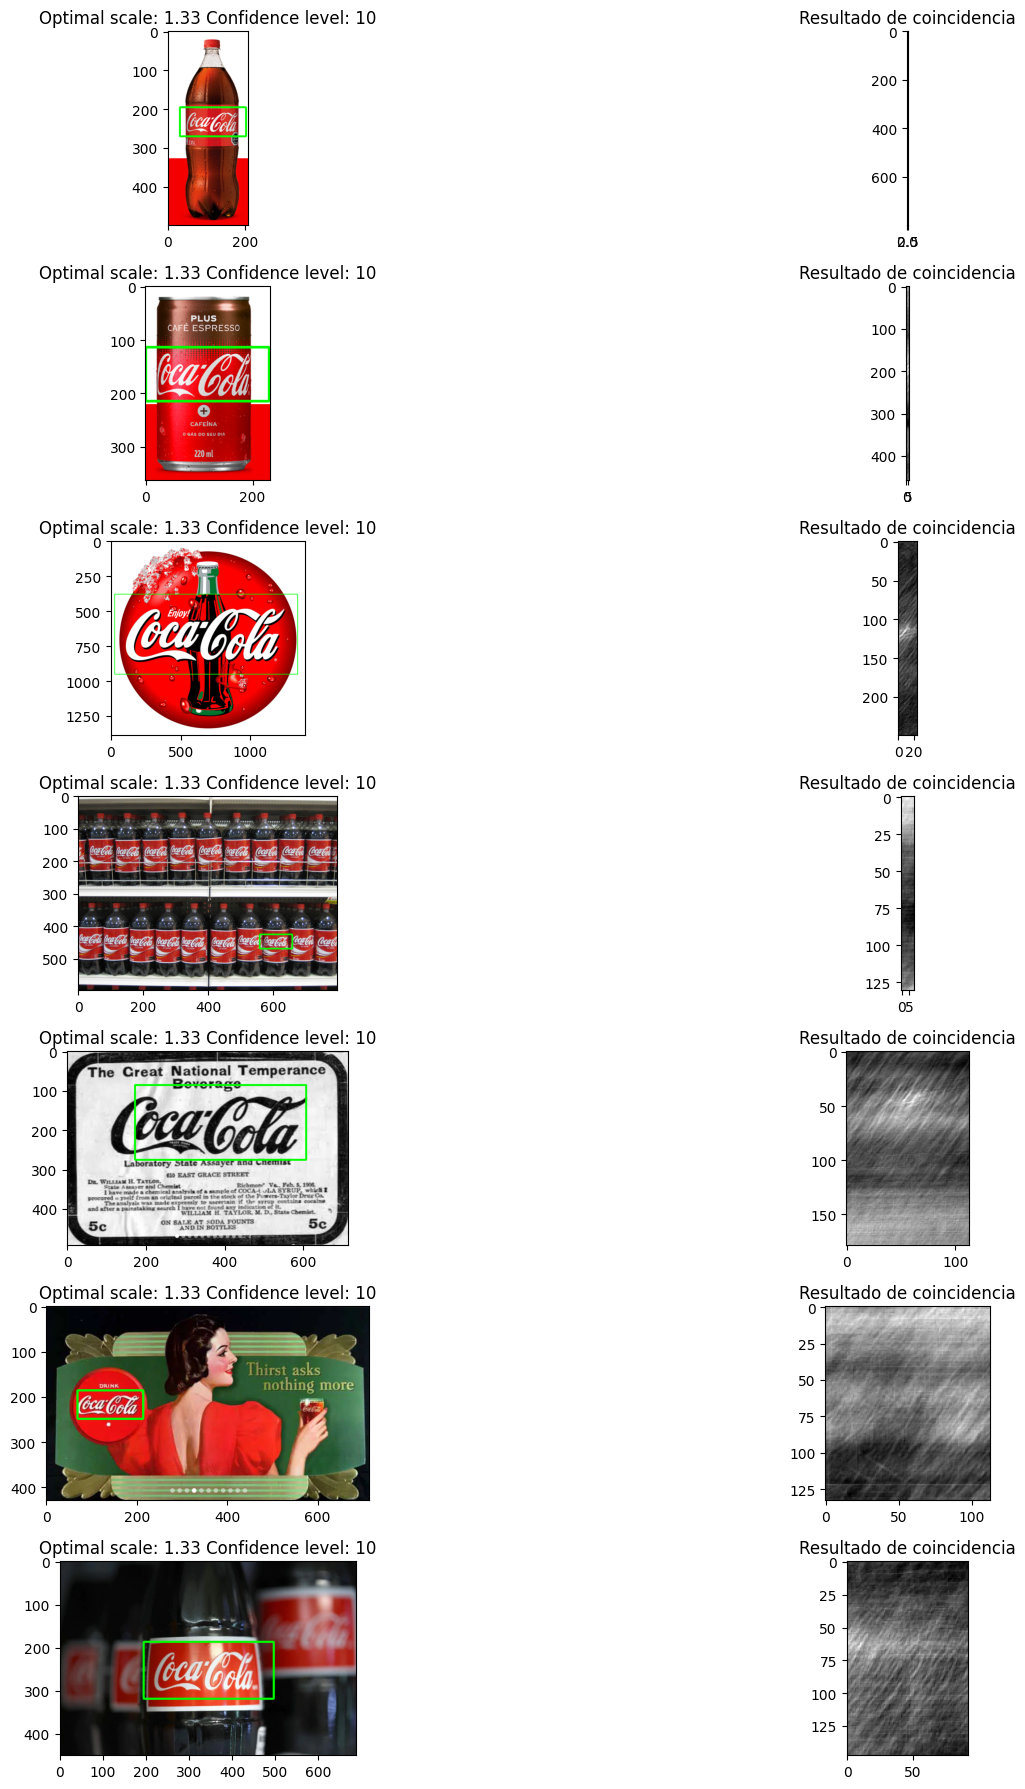

In [8]:
# Display images

titles = [f"Optimal scale: {round(optimal_scale, 2)} Confidence level: {int(max_val * 100)}" for _ in rgb_images]
display_images(detected_images, match_results, titles)

## 2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo témplate del ítem 1.

In [11]:
# Load an image from a file path
def load_image_from_file(file_path, color_space=cv.COLOR_BGR2RGB):
    image = cv.imread(file_path)
    image = cv.cvtColor(image, color_space)
    return image

# Apply the Canny edge detection algorithm to an image
def apply_edge_detection(image):
    edges = cv.Canny(image, 50, 200)
    return edges

def resize_image(image, scale):
    return cv.resize(image, None, fx=scale, fy=scale)

def apply_canny(image):
    return cv.Canny(image, 50, 200)

def match_template(image, template, method):
    return cv.matchTemplate(image, template, method)

def get_best_match(scales, gray_image, template, method):
    best_match_value = 0
    template_width, template_height = template.shape[::-1]

    for scale in scales:
        resized_image = resize_image(gray_image, scale)
        resized_width, resized_height = resized_image.shape[::-1]

        if resized_width < template_width or resized_height < template_height:
            break

        edge_image = apply_canny(resized_image)
        match_result = match_template(edge_image, template, method)
        _, max_val, _, _ = cv.minMaxLoc(match_result)

        if max_val > best_match_value:
            best_match_value = max_val
            best_scale = scale
            best_match_result = match_result

    return best_match_value, best_scale, best_match_result

def get_detection_boxes(locations, best_scale, template_width, template_height):
    detection_boxes = []
    for position in zip(*locations[::-1]):
        start_x = int(position[0] / best_scale)
        start_y = int(position[1] / best_scale)
        end_x = int((position[0] + template_width) / best_scale)
        end_y = int((position[1] + template_height) / best_scale)
        detection_boxes.append((start_x, start_y, end_x, end_y))
    return detection_boxes

def draw_boxes(image, boxes):
    for (startX, startY, endX, endY) in boxes:
        cv.rectangle(image, (startX, startY), (endX, endY), color=(0, 255, 0), thickness=2)
    return image

In [12]:
def detect_objects_in_image(gray_image, rgb_image, template, method, threshold=0.06):
    scales = np.linspace(0.1, 4.0, 20)[::-1]
    template_width, template_height = template.shape[::-1]

    best_match_value, best_scale, best_match_result = get_best_match(scales, gray_image, template, method)

    locations = np.where(best_match_result >= threshold)
    detection_boxes = get_detection_boxes(locations, best_scale, template_width, template_height)

    selected_boxes = non_max_suppression(np.array(detection_boxes))

    output_image = draw_boxes(rgb_image.copy(), selected_boxes)

    return output_image, best_match_value, best_match_result

In [13]:
# Load images and templates
multi_image_path = './images/coca_multi.png'
multi_image_rgb = load_image_from_file(multi_image_path)
multi_image_gray = load_image_from_file(multi_image_path, cv.COLOR_BGR2GRAY)
template = cv.imread(image_template_path, 0)
edge_template = apply_edge_detection(template)

In [14]:
# Detect multiple objects
method = eval('cv.TM_CCOEFF_NORMED')
detected_image, match_value, match_result = detect_objects_in_image(multi_image_gray, multi_image_rgb, edge_template, method)

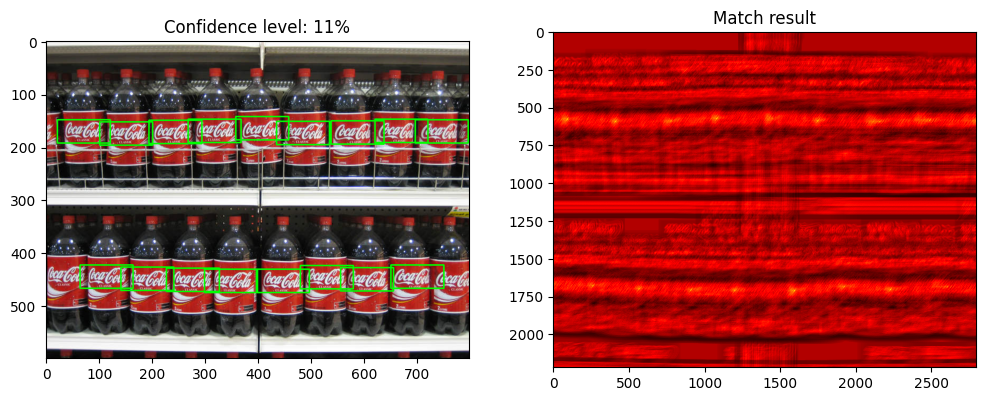

In [15]:
# Display images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(detected_image)
plt.title(f'Confidence level: {int(match_value * 100)}%')

# Display match result
plt.subplot(1, 2, 2)
plt.imshow(match_result, cmap='hot')
plt.title('Match result')
plt.show()

## 3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes.

In [16]:
def load_image(path, color=cv.COLOR_BGR2RGB):
    """Load an image from a file path."""
    return cv.cvtColor(cv.imread(path), color)

def apply_canny(image):
    """Apply Canny edge detection to an image."""
    return cv.Canny(image, 50, 200)

def resize_image(image, scale):
    return cv.resize(image, None, fx=scale, fy=scale)

def match_template(image, template, method):
    return cv.matchTemplate(image, template, method)

def get_best_match(scales, gray_image, template, method):
    best_match_value = 0
    template_width, template_height = template.shape[::-1]

    for scale in scales:
        resized_image = resize_image(gray_image, scale)
        if resized_image.shape[1] < template_width or resized_image.shape[0] < template_height:
            break

        edge_image = apply_canny(resized_image)
        match_result = match_template(edge_image, template, method)
        _, max_val, _, _ = cv.minMaxLoc(match_result)

        if max_val > best_match_value:
            best_match_value = max_val
            best_scale = scale
            best_match_result = match_result

    return best_match_value, best_scale, best_match_result

def get_detection_boxes(locations, best_scale, template_width, template_height):
    detection_boxes = [(int(pos[0] / best_scale), int(pos[1] / best_scale), 
                        int((pos[0] + template_width) / best_scale), int((pos[1] + template_height) / best_scale)) 
                       for pos in zip(*locations[::-1])]
    return detection_boxes

def draw_boxes(image, boxes):
    for (startX, startY, endX, endY) in boxes:
        cv.rectangle(image, (startX, startY), (endX, endY), color=(0, 255, 0), thickness=2)
    return image

In [17]:
def object_detection(gray_image, rgb_image, template, method, threshold=0.07):
    scales = np.linspace(0.1, 4.0, 55)[::-1]
    template_width, template_height = template.shape[::-1]

    best_match_value, best_scale, best_match_result = get_best_match(scales, gray_image, template, method)

    locations = np.where(best_match_result >= threshold)
    detection_boxes = get_detection_boxes(locations, best_scale, template_width, template_height)

    selected_boxes = non_max_suppression(np.array(detection_boxes))

    output_image = draw_boxes(rgb_image.copy(), selected_boxes)

    return output_image, best_match_value

In [18]:
def plot_images(images, titles):
    """Plot multiple images in a grid."""
    num_images = len(images)
    num_rows = math.ceil(num_images / 2)
    figure = plt.figure(figsize=(18,18))
    for i, (image, title) in enumerate(zip(images, titles)):
        figure.add_subplot(num_rows, 2, i+1)
        plt.imshow(image)
        plt.title(title)
    figure.tight_layout(pad=1)
    plt.show()

In [19]:
# Load images and templates
gray_images = [load_image(path, cv.COLOR_BGR2GRAY) for path in image_paths]
rgb_images = [load_image(path) for path in image_paths]
template = cv.imread(image_template_path, 0)
edge_template = apply_canny(template)

# Detect objects in all images
method = eval('cv.TM_CCOEFF_NORMED')
detected_images = []
confidence_levels = []

In [20]:
for i, (gray_image, rgb_image) in enumerate(zip(gray_images, rgb_images)):
    print(f"Processing image {i+1} of {len(gray_images)}")
    detected_image, confidence_level = object_detection(gray_image, rgb_image, edge_template, method)
    detected_images.append(detected_image)
    confidence_levels.append(f"Confidence level: {int(confidence_level * 100)}%")

Processing image 1 of 7
Processing image 2 of 7
Processing image 3 of 7
Processing image 4 of 7
Processing image 5 of 7
Processing image 6 of 7
Processing image 7 of 7


In [21]:
# Calculate grid size
num_images = len(detected_images)
grid_size = (math.ceil(num_images / math.ceil(math.sqrt(num_images))), math.ceil(math.sqrt(num_images)))

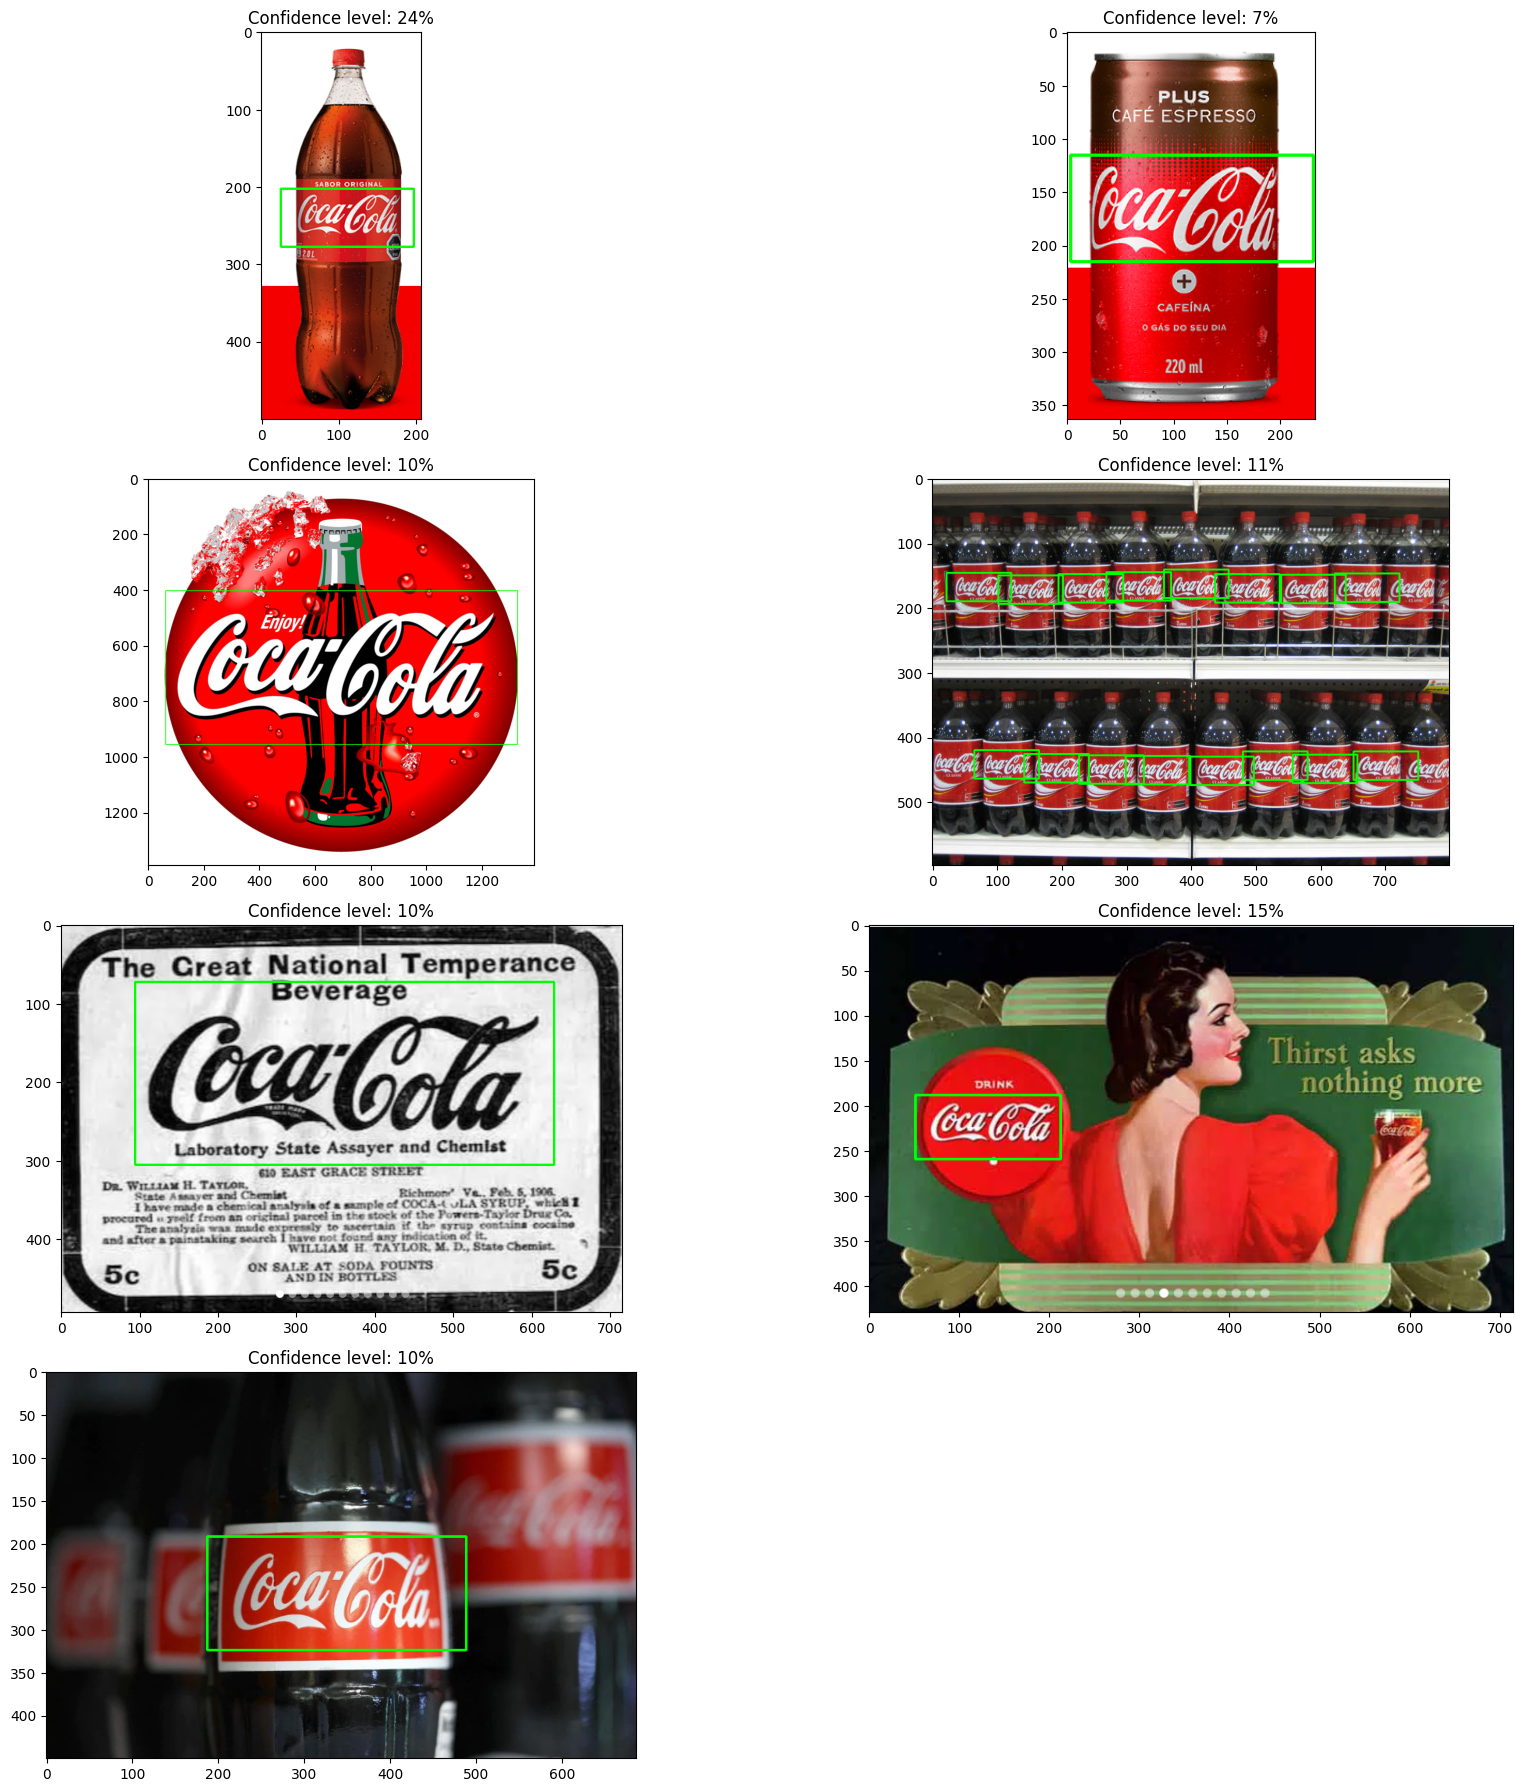

In [22]:
plot_images(detected_images, confidence_levels)